<a href="https://colab.research.google.com/github/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression with GRU

- Yongyang Liu


## Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


In [2]:
# Path to save the trained model
Path = os.getcwd()
PATH = "Trained_model/GRU.pth"

#CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Data Loading

In [3]:
x = np.loadtxt('Sample_data/input.txt', delimiter='\t')
print(x.shape)

y = np.loadtxt('Sample_data/output.txt', delimiter='\t')
print(y.shape)

time_len    = 320                                   #time length for sample data for each vehicle           
veh_len     = 5                                     #vehicle length
seq_length  = 5                                     #Input sequency lenght, should not be too long. Use the past seq-length sample data to predict the next step state

time_length = len(x)                                #time length for total sample data
num_veh     = int(time_length/time_len)             #number of vehicles in sample data
print(num_veh)

(288000, 3)
(288000,)
900


## Data Processing

In [4]:
training_size = 700
validation_size = 100
testing_size = 100

dataX       = Variable(torch.Tensor(np.array(x)))   #Input data
dataY       = Variable(torch.Tensor(np.array(y)))   #Output target
sample_len  = time_len - seq_length                 # sample length from each vehicle

#Samples initialization
trainX      = Variable(torch.empty(training_size*sample_len, seq_length, 3))
trainY      = Variable(torch.empty(training_size*sample_len, 1))
for j in range(training_size): 
    for i in range(sample_len):
        #input data
        trainX[j*sample_len+i,0:seq_length] = dataX[j*time_len+i : j*time_len+i+seq_length]
        #output target
        trainY[j*sample_len+i] = dataY[j*time_len+i+seq_length]       
print(trainX.shape)
print(trainY.shape)

validX      = Variable(torch.empty(validation_size*sample_len, seq_length, 3))
validY      = Variable(torch.empty(validation_size*sample_len, 1))
for j in range(validation_size): 
    for i in range(sample_len):
        j_0 = j + training_size   
        validX[j*sample_len+i,0:seq_length] = dataX[j_0*time_len+i : j_0*time_len+i+seq_length]       
        validY[j*sample_len+i] = dataY[j_0*time_len+i+seq_length]     
print(validX.shape)
print(validY.shape)

testX       = Variable(torch.empty(validation_size*sample_len, seq_length, 3)) 
testY       = Variable(torch.empty(validation_size*sample_len, 1))
for j in range(testing_size): 
    for i in range(sample_len):
        j_0 = j + training_size + validation_size
        testX[j*sample_len+i,0:seq_length] = dataX[j_0*time_len+i : j_0*time_len+i+seq_length]       
        testY[j*sample_len+i] = dataY[j_0*time_len+i+seq_length]     
print(testX.shape)
print(testY.shape)



#CUDA
trainX = trainX.to(device)
trainY = trainY.to(device)
validX = validX.to(device)
validY = validY.to(device)
testX = testX.to(device)
testY = testY.to(device)


torch.Size([220500, 5, 3])
torch.Size([220500, 1])
torch.Size([31500, 5, 3])
torch.Size([31500, 1])
torch.Size([31500, 5, 3])
torch.Size([31500, 1])


## Model

In [5]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size1, hidden_size2, num_layers): 
        super(GRU, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=hidden_size1, num_layers=num_layers, batch_first = True)
        self.gru2 = nn.GRU(input_size=hidden_size1, hidden_size=hidden_size2, num_layers=num_layers, batch_first = True)
        
        self.fc1 = nn.Linear(hidden_size2, int(hidden_size2/2))
        self.bn1 = nn.BatchNorm1d(int(hidden_size2/2))
        self.fc2 = nn.Linear(int(hidden_size2/2), int(hidden_size2/4))  
        self.bn2 = nn.BatchNorm1d(int(hidden_size2/4))
        self.fc3 = nn.Linear(int(hidden_size2/4), num_classes)
        
        self.drop1 = nn.Dropout(p=0.5)
        self.drop2 = nn.Dropout(p=0.5)

    def forward(self, x):
        h_00 = Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size1)).to(device)
        h_01 = Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size2)).to(device)
        
        # Propagate input through RNN
        out, _ = self.gru1(x, h_00)
        uls, h_out = self.gru2(out, h_01)          # seq_2_one, so we use h_out instead of uls
        
        h_out = h_out.view(-1, self.hidden_size2)
        output = F.relu(self.drop1(self.bn1(self.fc1(h_out))))
        output = F.relu(self.drop2(self.bn2(self.fc2(output))))
        output = self.fc3(output)
        
        return output

## Training

Model's state_dict:
gru1.weight_ih_l0 	 torch.Size([384, 3])
gru1.weight_hh_l0 	 torch.Size([384, 128])
gru1.bias_ih_l0 	 torch.Size([384])
gru1.bias_hh_l0 	 torch.Size([384])
gru2.weight_ih_l0 	 torch.Size([192, 128])
gru2.weight_hh_l0 	 torch.Size([192, 64])
gru2.bias_ih_l0 	 torch.Size([192])
gru2.bias_hh_l0 	 torch.Size([192])
fc1.weight 	 torch.Size([32, 64])
fc1.bias 	 torch.Size([32])
bn1.weight 	 torch.Size([32])
bn1.bias 	 torch.Size([32])
bn1.running_mean 	 torch.Size([32])
bn1.running_var 	 torch.Size([32])
bn1.num_batches_tracked 	 torch.Size([])
fc2.weight 	 torch.Size([16, 32])
fc2.bias 	 torch.Size([16])
bn2.weight 	 torch.Size([16])
bn2.bias 	 torch.Size([16])
bn2.running_mean 	 torch.Size([16])
bn2.running_var 	 torch.Size([16])
bn2.num_batches_tracked 	 torch.Size([])
fc3.weight 	 torch.Size([1, 16])
fc3.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'par

C:\Users\yliu3119\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\yliu3119\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


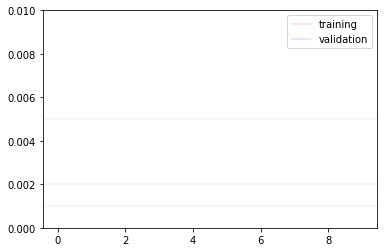

Epoch: 10, loss_train: 0.003977656830, loss_valid: 0.004423075356, best loss: 0.003845119150
Epoch: 20, loss_train: 0.002461677883, loss_valid: 0.002668102970, best loss: 0.002454340924
Epoch: 30, loss_train: 0.002381643048, loss_valid: 0.002189368475, best loss: 0.002189368475
Epoch: 40, loss_train: 0.002115329029, loss_valid: 0.002044940833, best loss: 0.001928043435
Epoch: 50, loss_train: 0.001809178968, loss_valid: 0.001839729259, best loss: 0.001803150983
Epoch L1 regularization 0.00000005


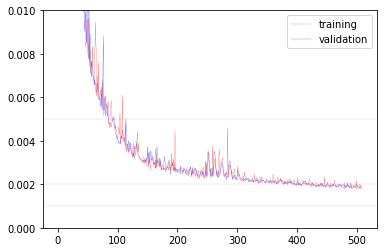

Epoch: 60, loss_train: 0.001811449532, loss_valid: 0.001754412777, best loss: 0.001666989294
Epoch: 70, loss_train: 0.001752271201, loss_valid: 0.001612034393, best loss: 0.001564098638
Epoch: 80, loss_train: 0.001605283585, loss_valid: 0.001542515354, best loss: 0.001519472920
Epoch: 90, loss_train: 0.001508877496, loss_valid: 0.001502436120, best loss: 0.001437957399
Epoch: 100, loss_train: 0.001534024952, loss_valid: 0.001484634820, best loss: 0.001426723204
Epoch L1 regularization 0.00000005


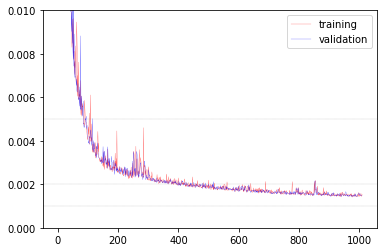

Epoch: 110, loss_train: 0.001485862886, loss_valid: 0.001537325792, best loss: 0.001380954403
Epoch: 120, loss_train: 0.001489926479, loss_valid: 0.001405099523, best loss: 0.001374460408
Epoch: 130, loss_train: 0.001548174419, loss_valid: 0.001438208274, best loss: 0.001344841090
Epoch: 140, loss_train: 0.001425445080, loss_valid: 0.001534058363, best loss: 0.001344841090
Epoch: 150, loss_train: 0.001499332371, loss_valid: 0.001375576132, best loss: 0.001332097454
Epoch L1 regularization 0.00000005


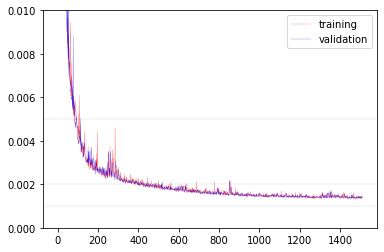

Epoch: 160, loss_train: 0.001539694029, loss_valid: 0.001373038278, best loss: 0.001330968458
Epoch: 170, loss_train: 0.001397274435, loss_valid: 0.001370975981, best loss: 0.001316575333
Epoch: 180, loss_train: 0.001400525915, loss_valid: 0.001342815114, best loss: 0.001316021197
Epoch: 190, loss_train: 0.001455144724, loss_valid: 0.001361584058, best loss: 0.001304409234
Epoch: 200, loss_train: 0.001368673751, loss_valid: 0.001363834948, best loss: 0.001295559807
Epoch L1 regularization 0.00000005


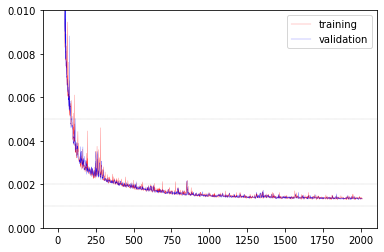

Epoch: 210, loss_train: 0.001389372163, loss_valid: 0.001306006801, best loss: 0.001295559807
Epoch: 220, loss_train: 0.001418103813, loss_valid: 0.001350711798, best loss: 0.001274985261
Epoch: 230, loss_train: 0.001335686538, loss_valid: 0.001305136713, best loss: 0.001264706487
Epoch: 240, loss_train: 0.001335646957, loss_valid: 0.001315447385, best loss: 0.001252303133
Epoch: 250, loss_train: 0.001402600785, loss_valid: 0.001405814080, best loss: 0.001228651963
Epoch L1 regularization 0.00000005


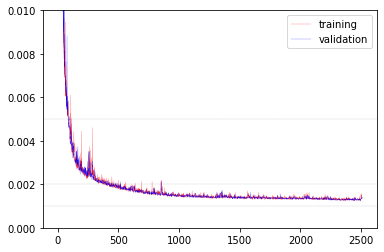

Epoch: 260, loss_train: 0.001338850125, loss_valid: 0.001288775238, best loss: 0.001228651963
Epoch: 270, loss_train: 0.001288159285, loss_valid: 0.001327182865, best loss: 0.001228651963
Epoch: 280, loss_train: 0.001331828651, loss_valid: 0.001325451303, best loss: 0.001228651963
Epoch: 290, loss_train: 0.001314375899, loss_valid: 0.001258690725, best loss: 0.001228651963
Epoch: 300, loss_train: 0.001312722219, loss_valid: 0.001263586455, best loss: 0.001226624823
Epoch L1 regularization 0.00000005


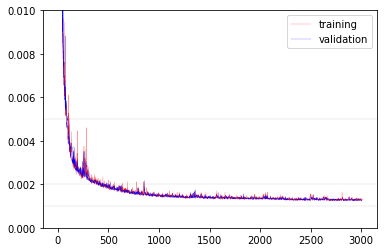

In [6]:
#hidden size is bigger, the accuracy is higher, but higher computation
#if the learning rate is too big, then loss may be stuck at a certain 
#and cannot go down. So, if the loss goes down to a certain value and
#then cannot decrease, just change a smaller learning rate.


num_epochs    = 301
learning_rate = 0.001
L1_lambda     = 0.00000000001

input_size   = trainX.size(2)
hidden_size1 = 128
hidden_size2 = 64
num_classes = trainY.size(1)
num_layers = 1

model = GRU(num_classes, input_size, hidden_size1, hidden_size2, num_layers) 
model.to(device)  #CUDA

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#learning rate adjustment. learning rate * 0.75 every 2000 epoch
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.75)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

best_loss = 99999999999999.99
best_epoch = 0
Loss = [] 
Loss_t = []
t_len = int(trainX.size(0)/10)
# Train the model

for epoch in range(num_epochs):   
    for j in range(10):     # input size is too big. We split into 10 piece
        torch.cuda.empty_cache()
        train_X_temp = trainX[j*t_len:j*t_len+t_len] # 0 to test_size
        train_Y_temp = trainY[j*t_len:j*t_len+t_len]
        
        train_X_temp = train_X_temp.to(device)
        train_Y_temp = train_Y_temp.to(device)
        
        outputs = model(train_X_temp)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, train_Y_temp)
        # L1 regularization
        L1_reg = torch.tensor(0., requires_grad=True)
        for name, param in model.named_parameters():
            if 'weight' in name:
                L1_reg = L1_reg + torch.norm(param, 1)
            
        loss += L1_lambda * L1_reg

        loss.backward()
        
        optimizer.step()
        #scheduler.step()
        
        outputs = model(testX)
        loss_t = criterion(outputs, testY)# + L1_lambda * L1_reg
    
        Loss.append(loss.item())
        Loss_t.append(loss_t.item())
        
        if loss_t.item() < best_loss:
            torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        }, PATH)
            best_loss = loss_t.item()
    
    if epoch % 10 == 0:
        print("Epoch: %d, loss_train: %1.12f, loss_valid: %1.12f, best loss: %1.12f" % (epoch, loss.item(), loss_t.item(), best_loss))
              
    if epoch % 50 == 0:
        print("Epoch L1 regularization %1.8f" % (L1_lambda * L1_reg))
        plt.plot(Loss,c='r', linewidth=0.2, Label = 'training')
        plt.plot(Loss_t,c='b', linewidth=0.2, Label = 'validation')
        plt.ylim(0, 0.01)
        plt.axhline(y=0.005, c='black', linestyle='--', linewidth=0.1)
        plt.axhline(y=0.002, c='black', linestyle='--', linewidth=0.1)
        plt.axhline(y=0.001, c='black', linestyle='--', linewidth=0.1)
        plt.legend()
        plt.show()



## Save model

In [37]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

## Load model

In [7]:
num_epochs    = 301
learning_rate = 0.001
L1_lambda     = 0.00000000001

input_size   = trainX.size(2)
hidden_size1 = 128
hidden_size2 = 64
num_classes = trainY.size(1)
num_layers = 1

model = GRU(num_classes, input_size, hidden_size1, hidden_size2, num_layers) 
model.to(device)  #CUDA

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if device == "cuda:0":
    checkpoint = torch.load(PATH)
else:
    checkpoint = torch.load(PATH, map_location = torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


## Test

vehicle 0  MSE Loss: 0.00141719


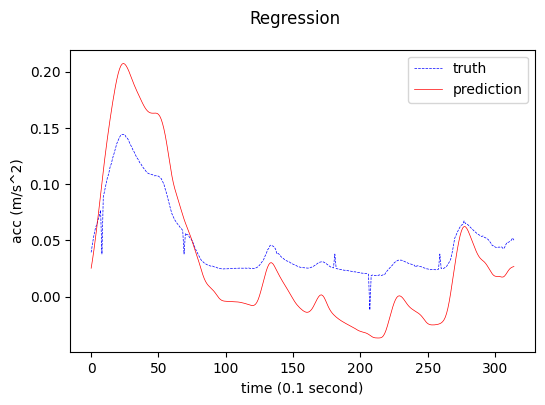

vehicle 1  MSE Loss: 0.00364591


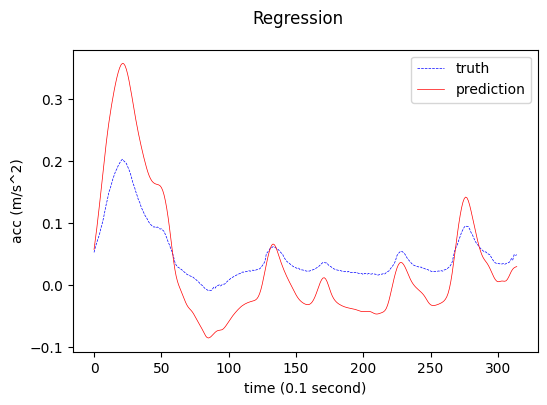

vehicle 2  MSE Loss: 0.00231955


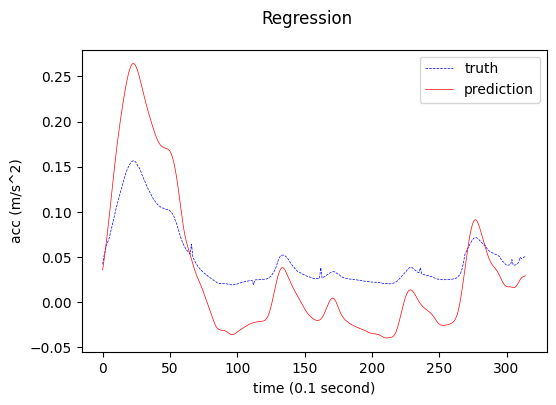

vehicle 3  MSE Loss: 0.00153200


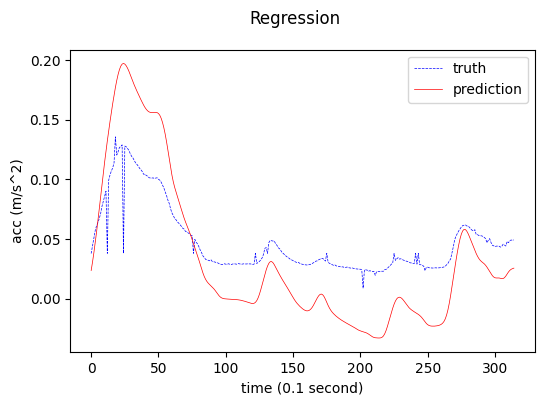

vehicle 4  MSE Loss: 0.00272695


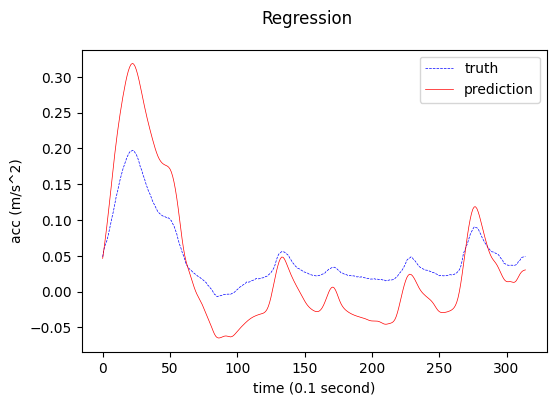

vehicle 5  MSE Loss: 0.00188353


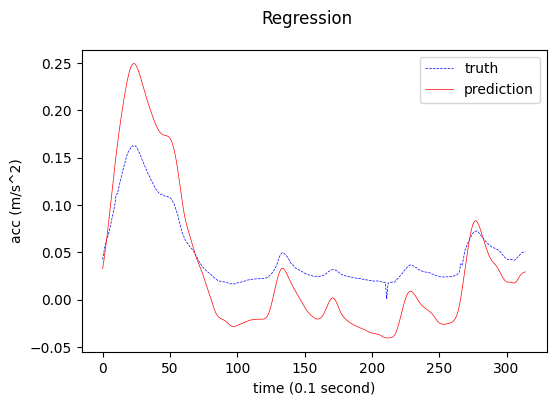

vehicle 6  MSE Loss: 0.00181106


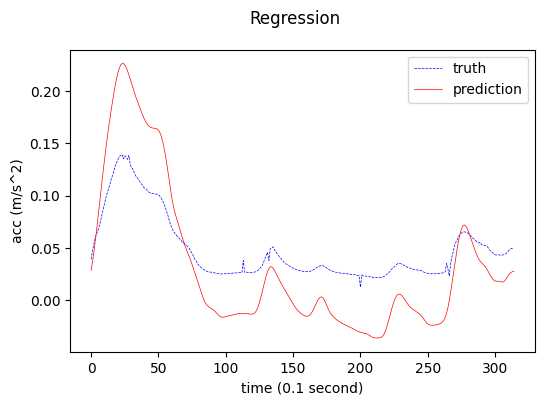

vehicle 7  MSE Loss: 0.00270603


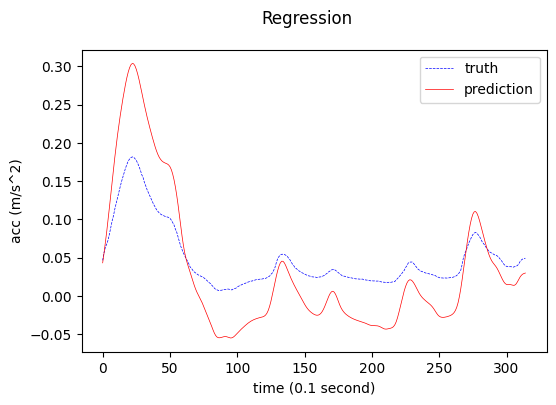

vehicle 8  MSE Loss: 0.00205327


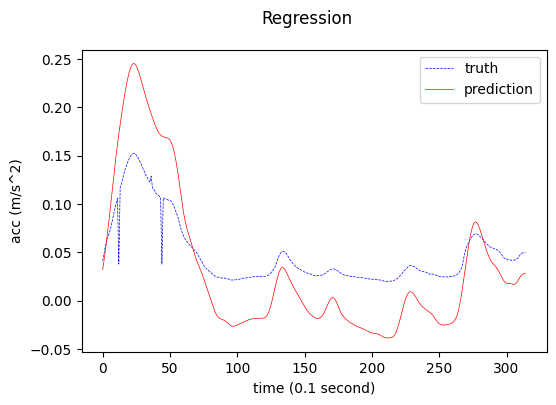

vehicle 9  MSE Loss: 0.00166455


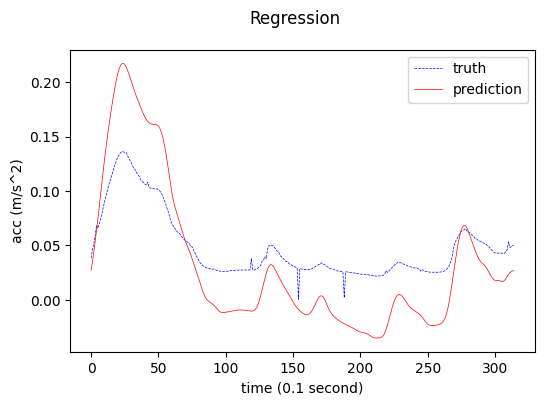

vehicle 10  MSE Loss: 0.00249365


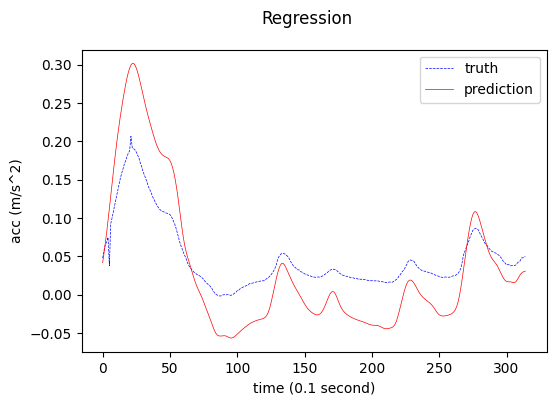

vehicle 11  MSE Loss: 0.00259258


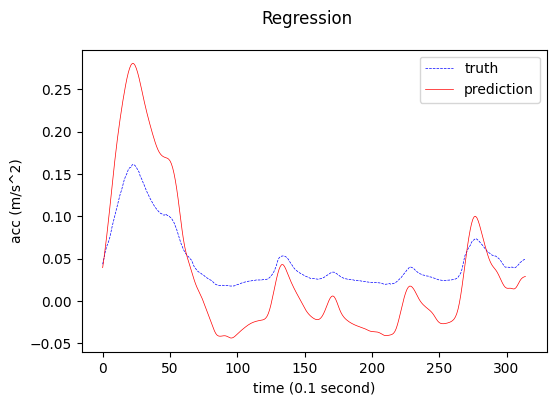

vehicle 12  MSE Loss: 0.00171612


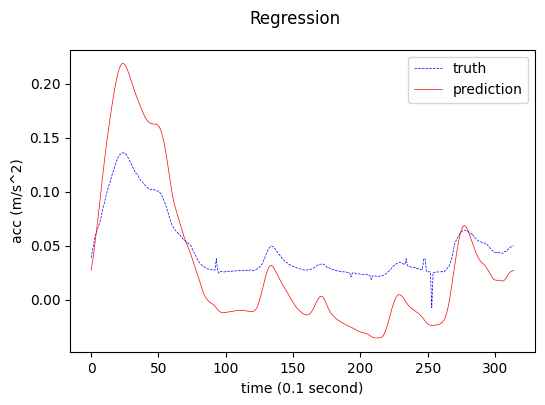

vehicle 13  MSE Loss: 0.00273898


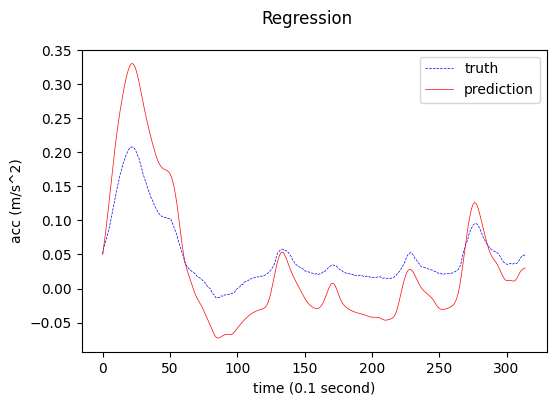

vehicle 14  MSE Loss: 0.00209842


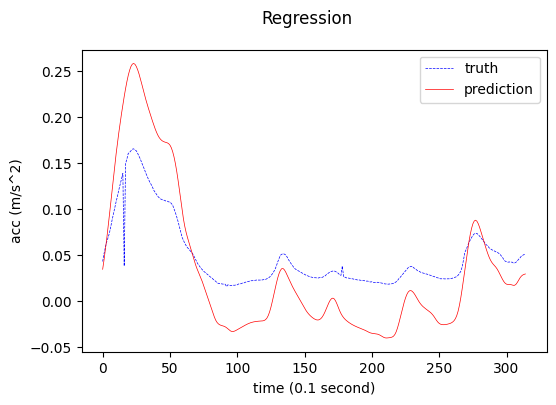

vehicle 15  MSE Loss: 0.00189625


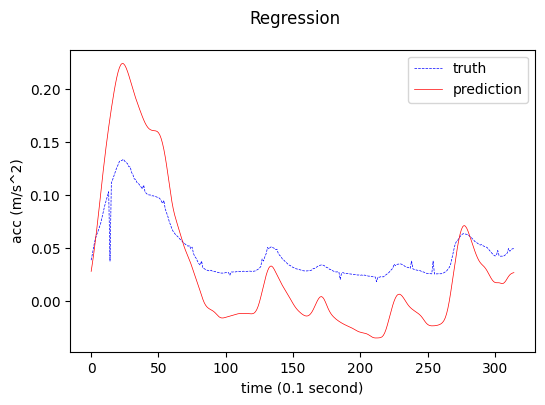

vehicle 16  MSE Loss: 0.00251858


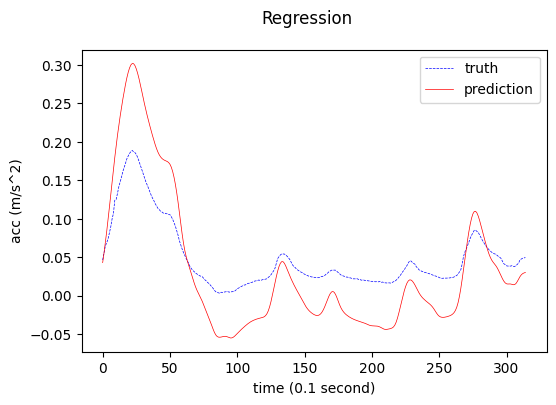

vehicle 17  MSE Loss: 0.00198864


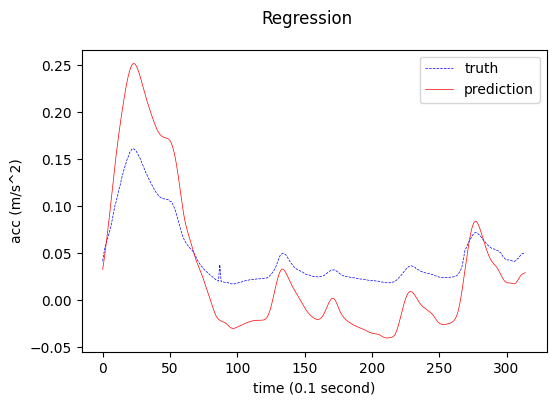

vehicle 18  MSE Loss: 0.00164902


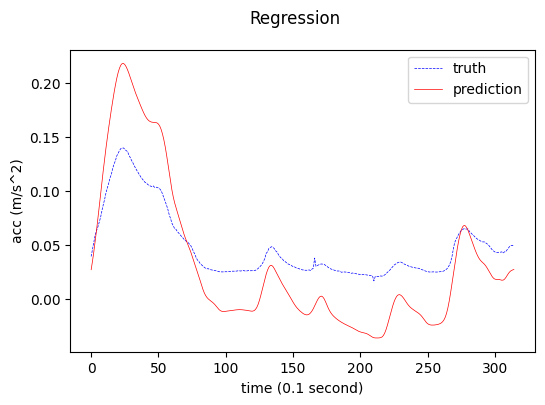

vehicle 19  MSE Loss: 0.00352873


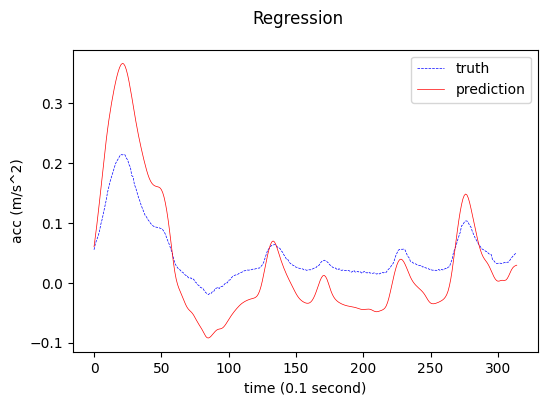

vehicle 20  MSE Loss: 0.00157669


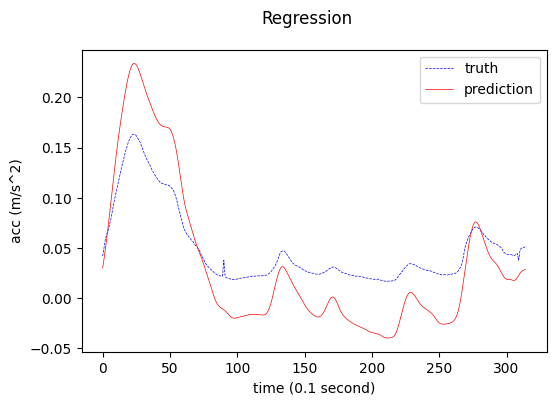

vehicle 21  MSE Loss: 0.00120514


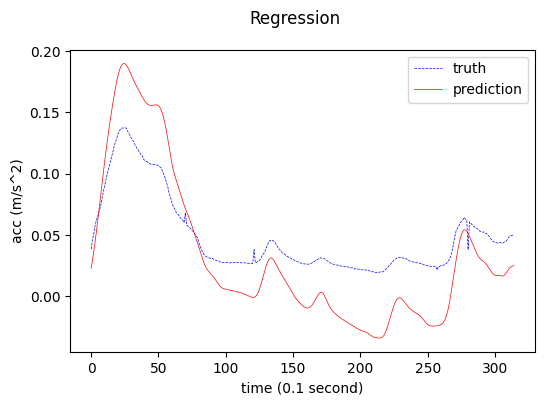

vehicle 22  MSE Loss: 0.00277552


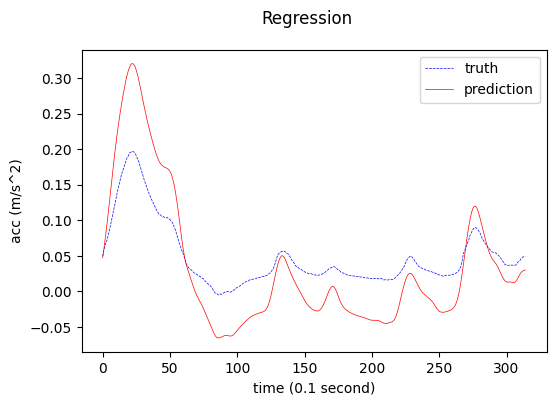

vehicle 23  MSE Loss: 0.00237388


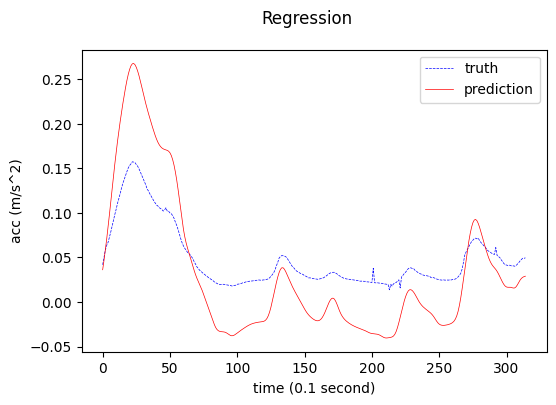

vehicle 24  MSE Loss: 0.00170027


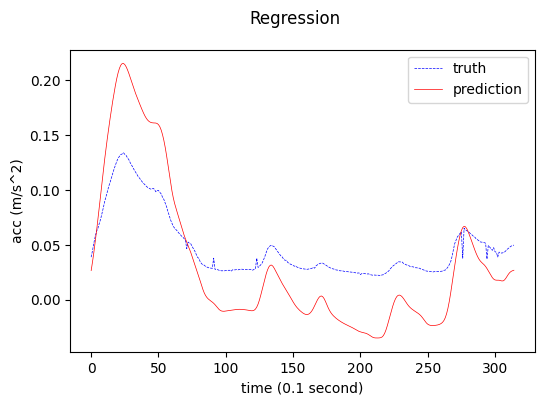

vehicle 25  MSE Loss: 0.00255796


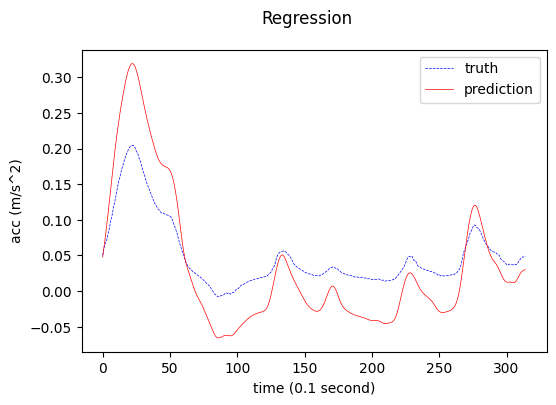

vehicle 26  MSE Loss: 0.00208945


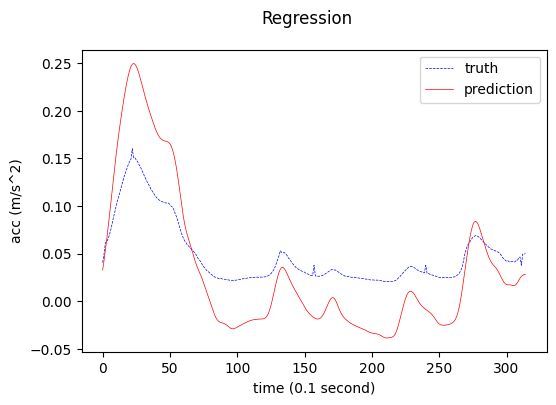

vehicle 27  MSE Loss: 0.00163746


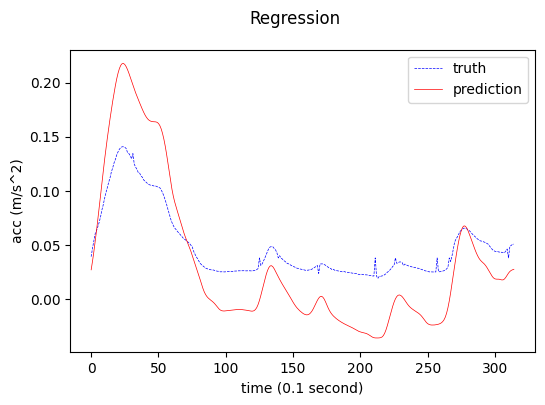

vehicle 28  MSE Loss: 0.00272313


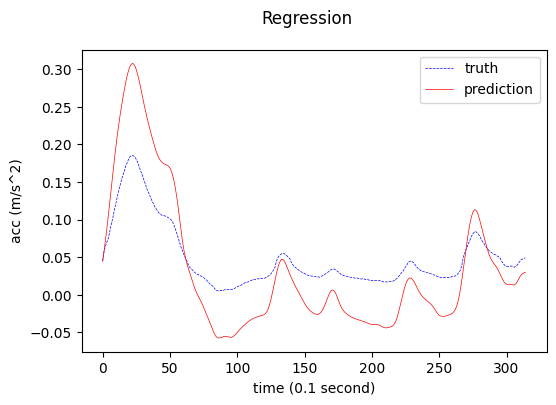

vehicle 29  MSE Loss: 0.00230875


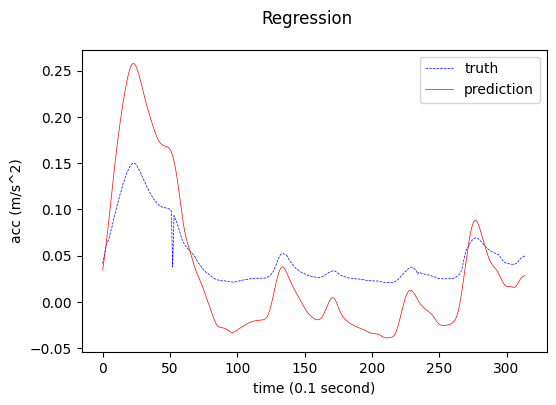

vehicle 30  MSE Loss: 0.00177931


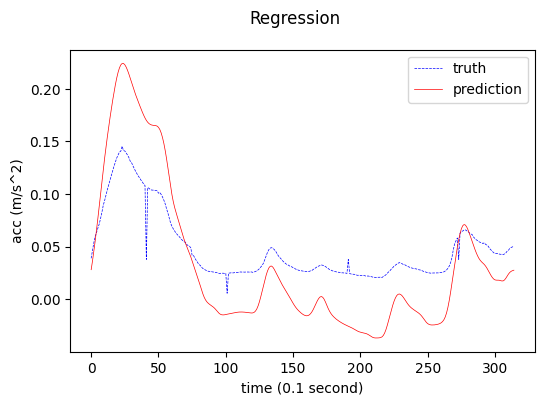

vehicle 31  MSE Loss: 0.00285561


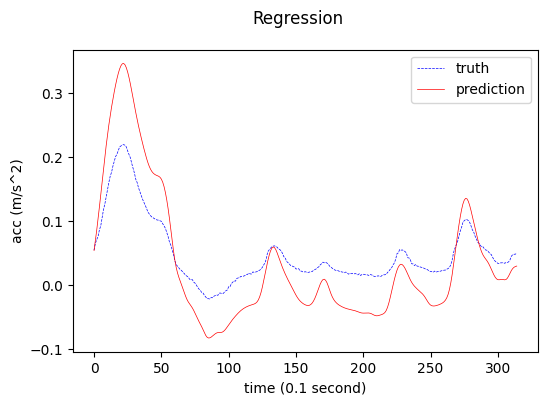

vehicle 32  MSE Loss: 0.00201401


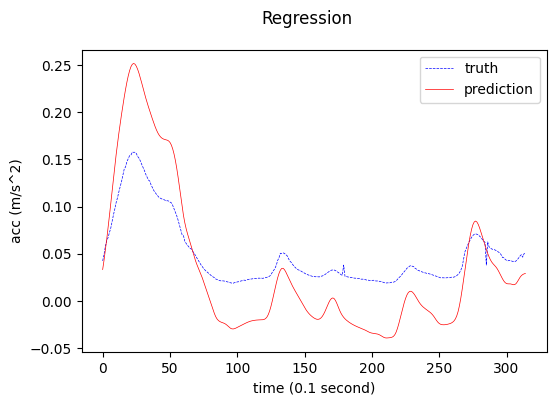

vehicle 33  MSE Loss: 0.00164751


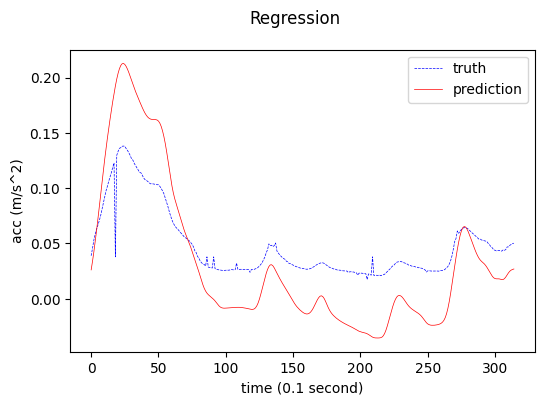

vehicle 34  MSE Loss: 0.00290206


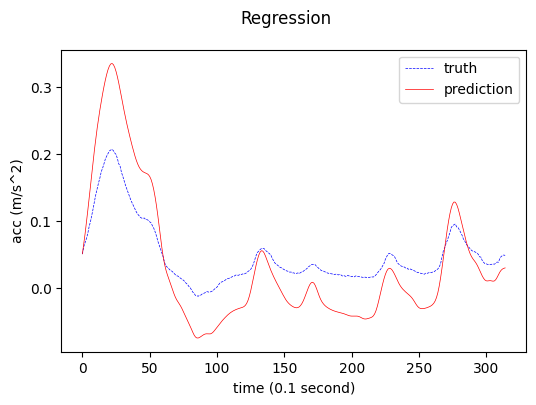

vehicle 35  MSE Loss: 0.00192632


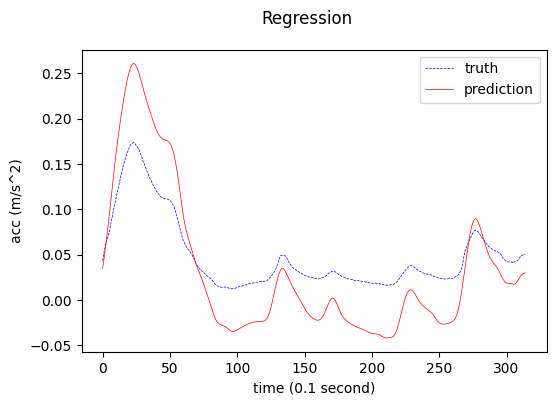

vehicle 36  MSE Loss: 0.00177136


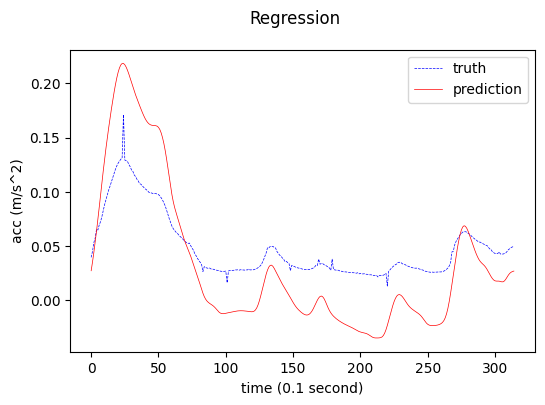

vehicle 37  MSE Loss: 0.00320722


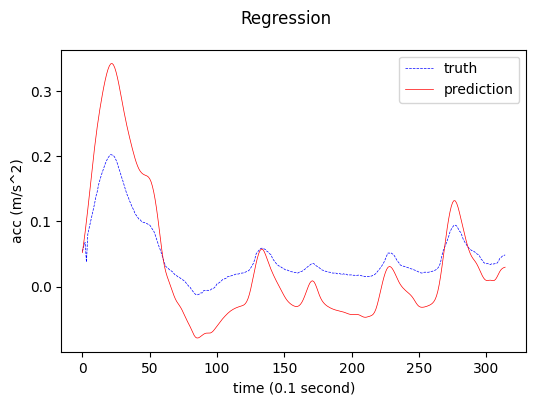

vehicle 38  MSE Loss: 0.00265620


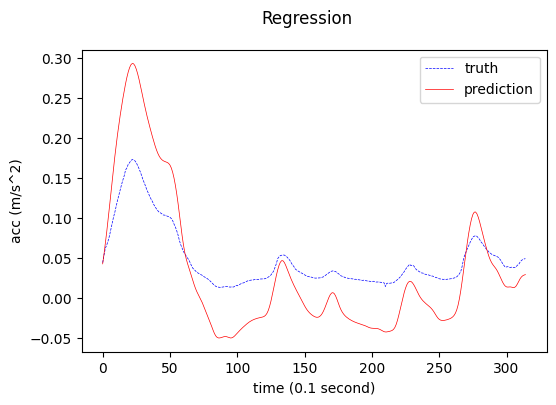

vehicle 39  MSE Loss: 0.00209686


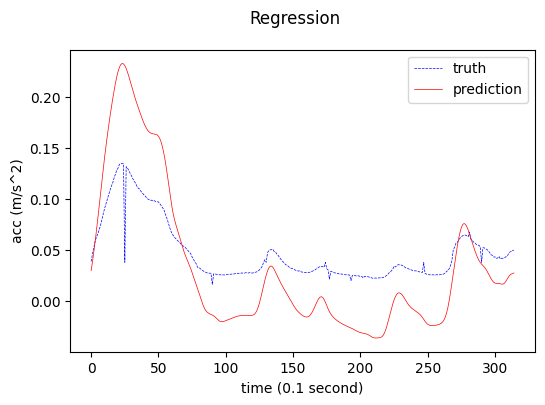

vehicle 40  MSE Loss: 0.00314510


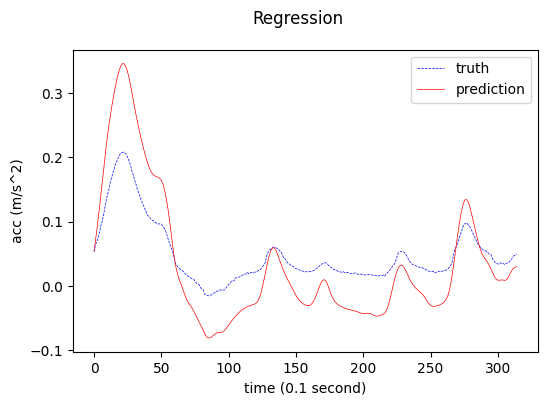

vehicle 41  MSE Loss: 0.00237388


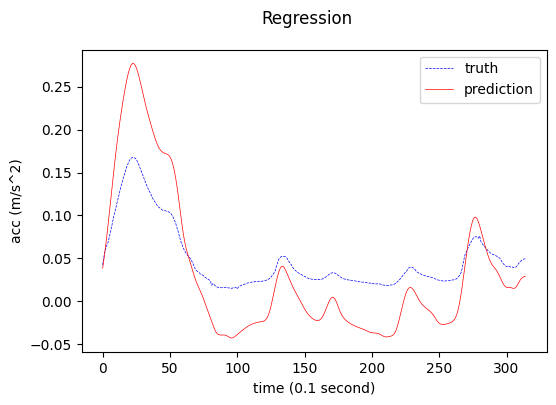

vehicle 42  MSE Loss: 0.00186700


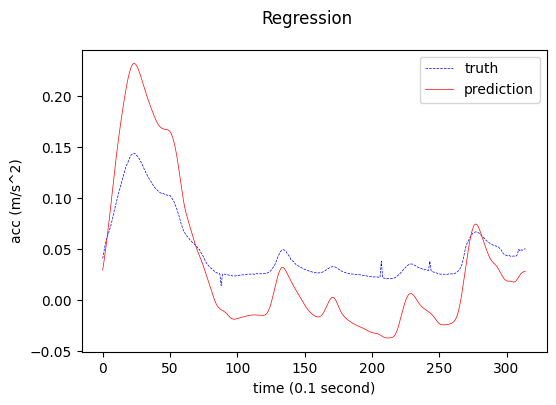

vehicle 43  MSE Loss: 0.00254290


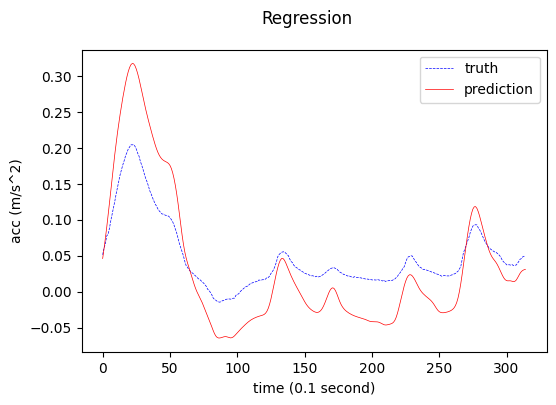

vehicle 44  MSE Loss: 0.00229266


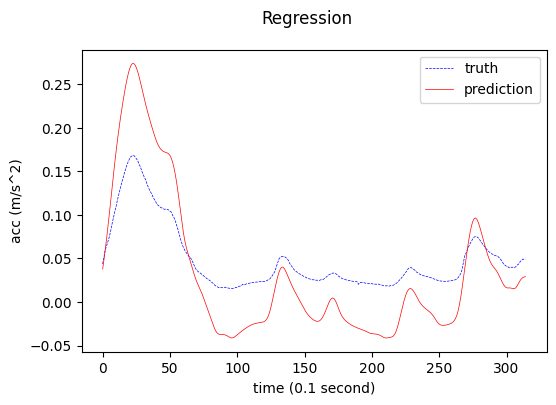

vehicle 45  MSE Loss: 0.00180976


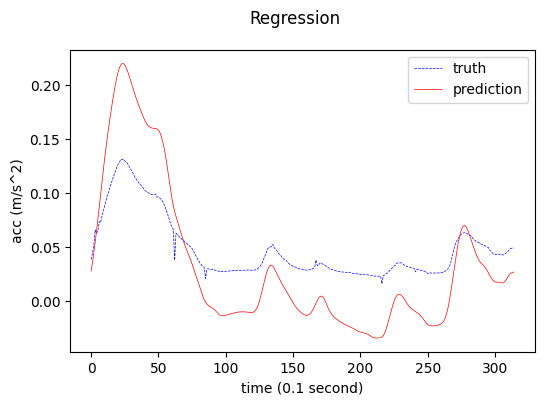

vehicle 46  MSE Loss: 0.00231247


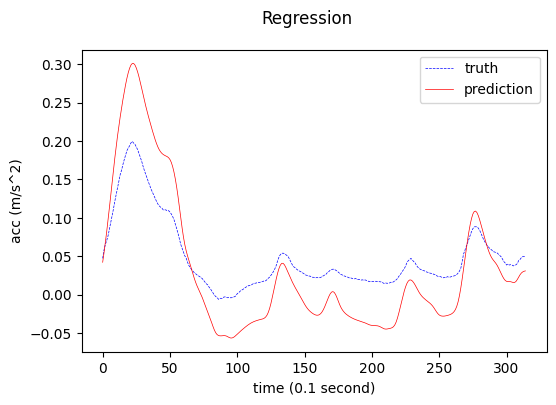

vehicle 47  MSE Loss: 0.00192903


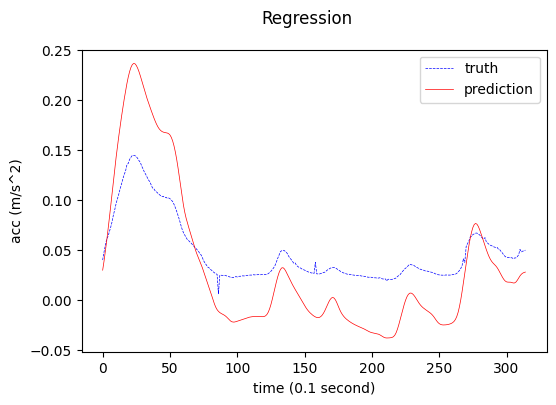

vehicle 48  MSE Loss: 0.00162298


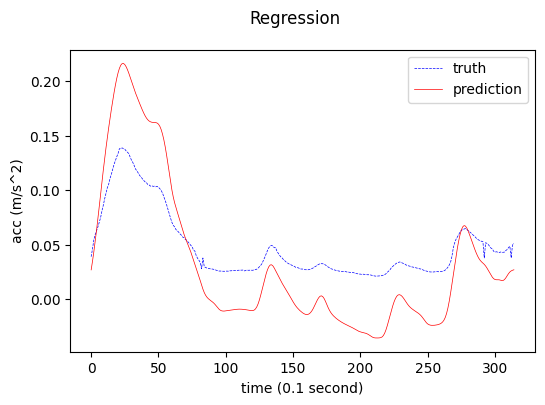

vehicle 49  MSE Loss: 0.00312562


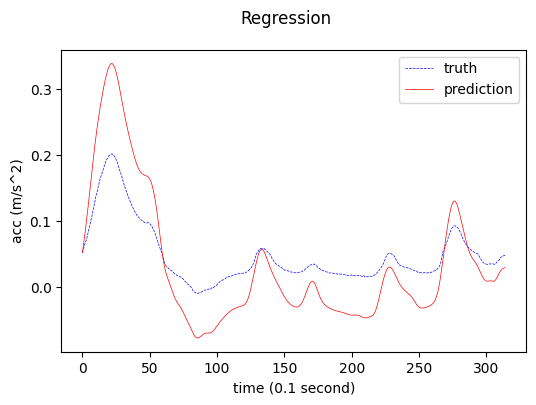

vehicle 50  MSE Loss: 0.00212821


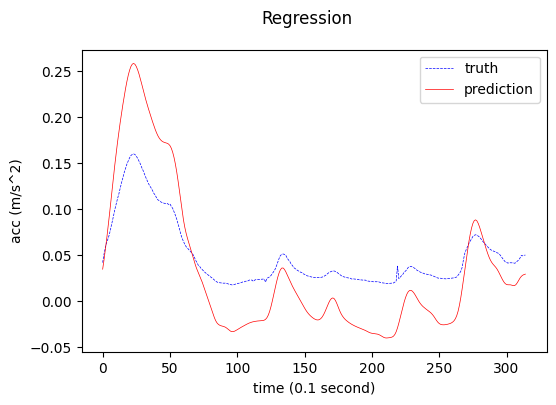

vehicle 51  MSE Loss: 0.00158194


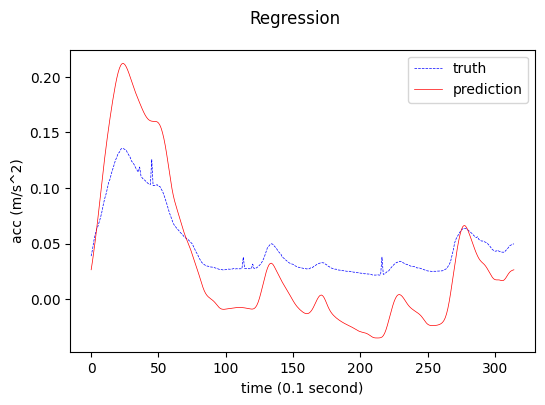

vehicle 52  MSE Loss: 0.00240908


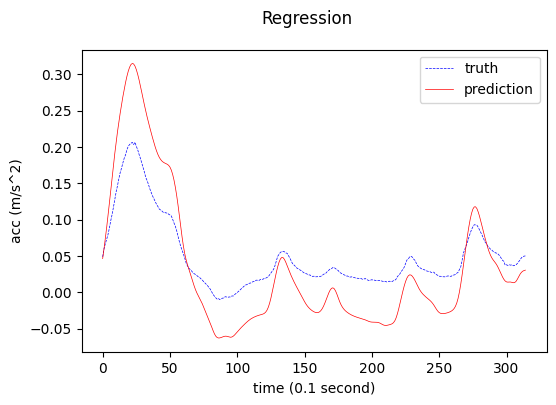

vehicle 53  MSE Loss: 0.00235203


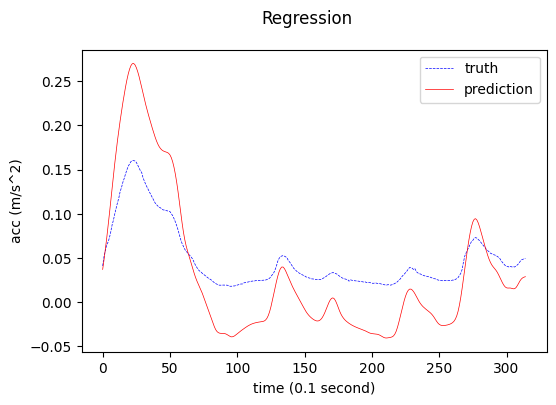

vehicle 54  MSE Loss: 0.00184431


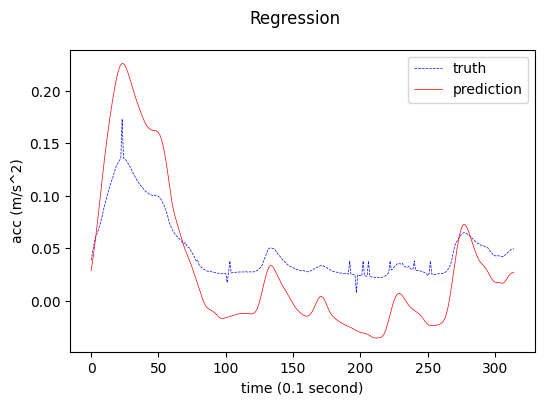

vehicle 55  MSE Loss: 0.00321774


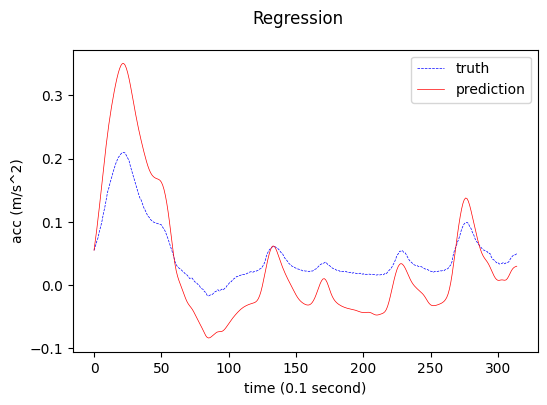

vehicle 56  MSE Loss: 0.00180264


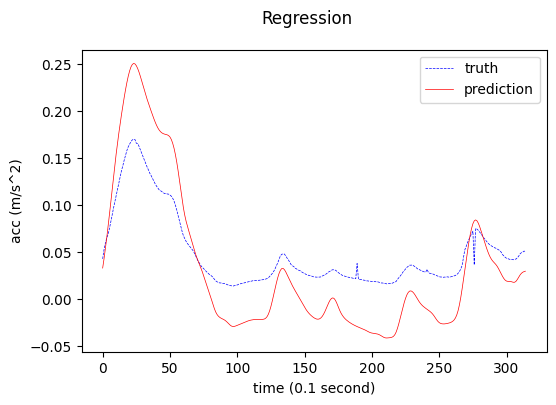

vehicle 57  MSE Loss: 0.00216352


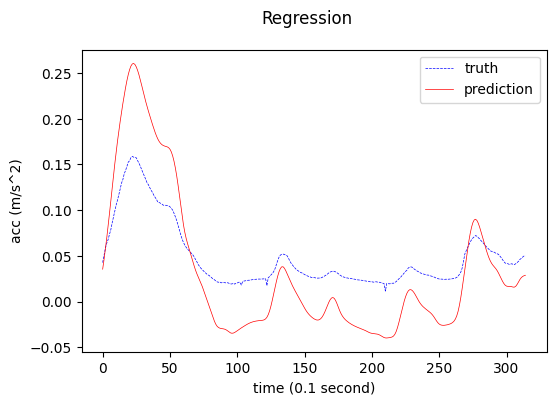

vehicle 58  MSE Loss: 0.00331634


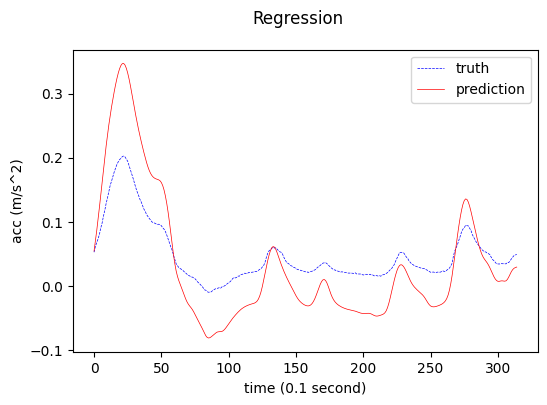

vehicle 59  MSE Loss: 0.00239173


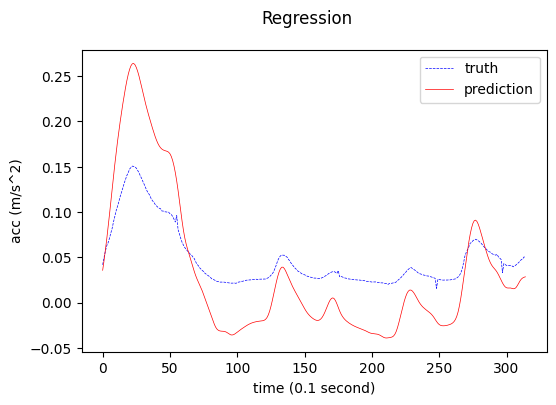

vehicle 60  MSE Loss: 0.00127635


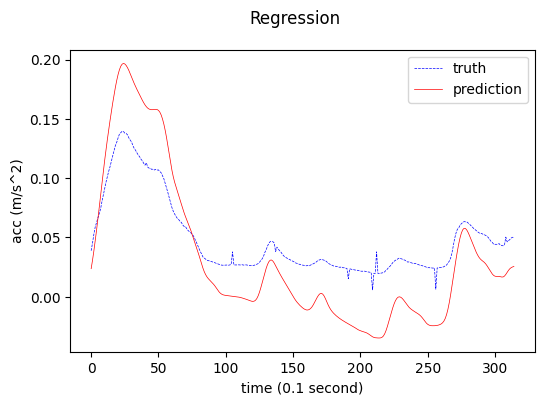

vehicle 61  MSE Loss: 0.00251021


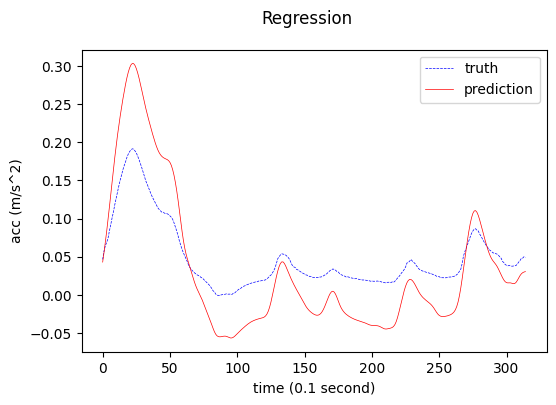

vehicle 62  MSE Loss: 0.00205749


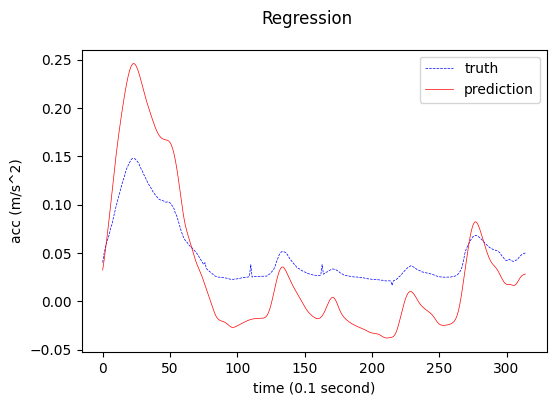

vehicle 63  MSE Loss: 0.00185960


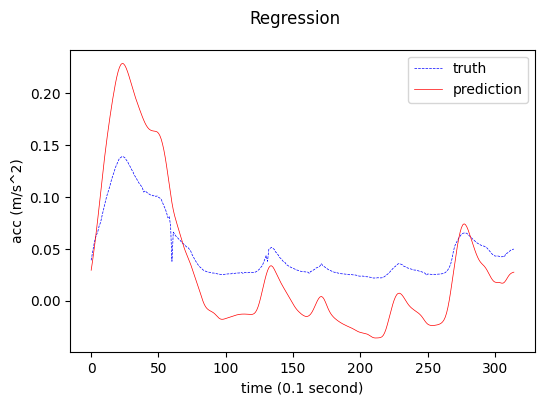

vehicle 64  MSE Loss: 0.00350252


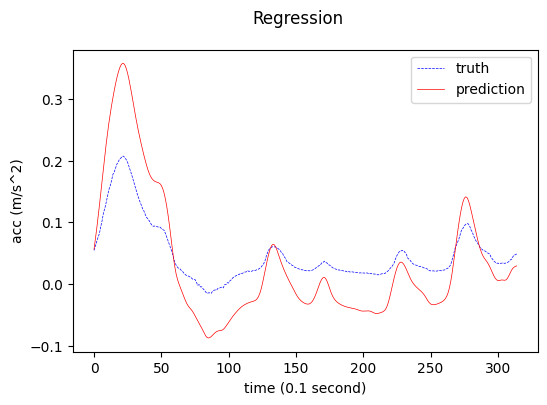

vehicle 65  MSE Loss: 0.00192879


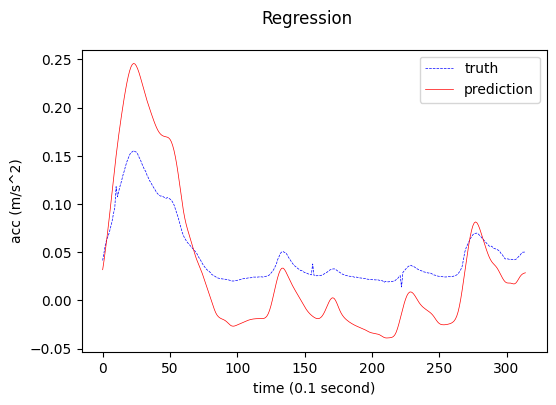

vehicle 66  MSE Loss: 0.00175941


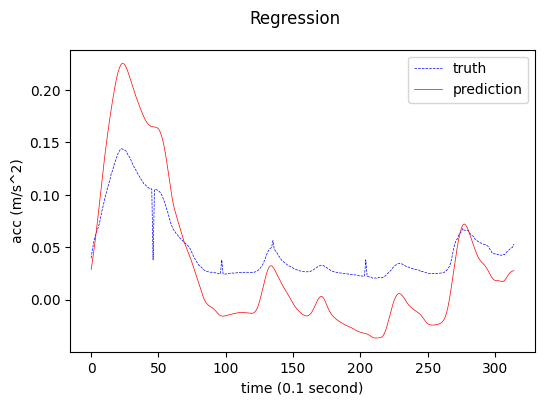

vehicle 67  MSE Loss: 0.00251373


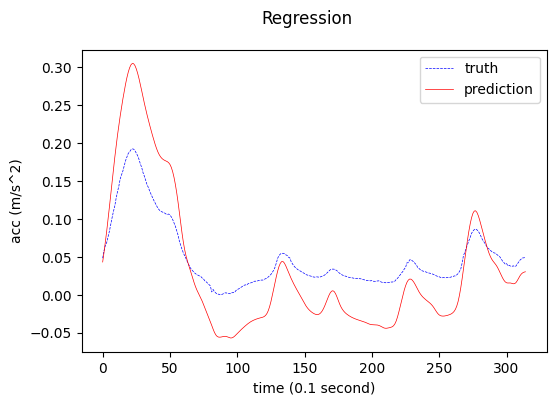

vehicle 68  MSE Loss: 0.00200108


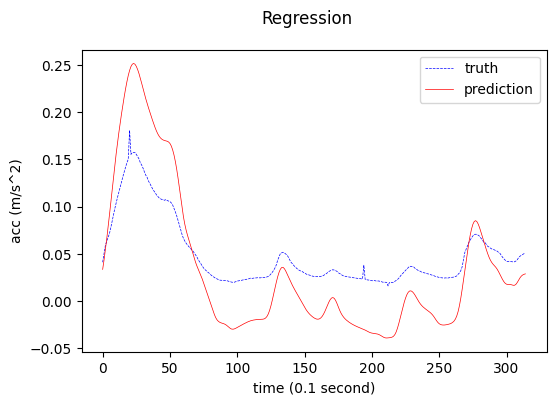

vehicle 69  MSE Loss: 0.00182721


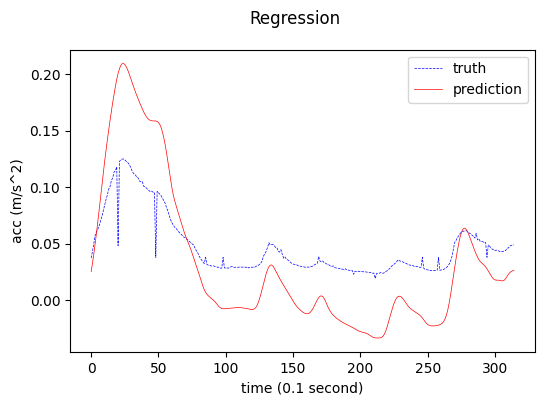

vehicle 70  MSE Loss: 0.00510610


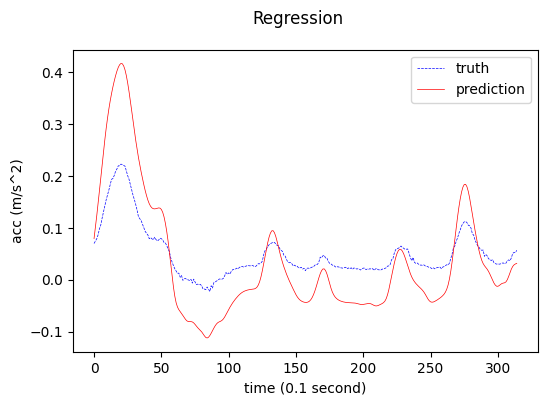

vehicle 71  MSE Loss: 0.00240675


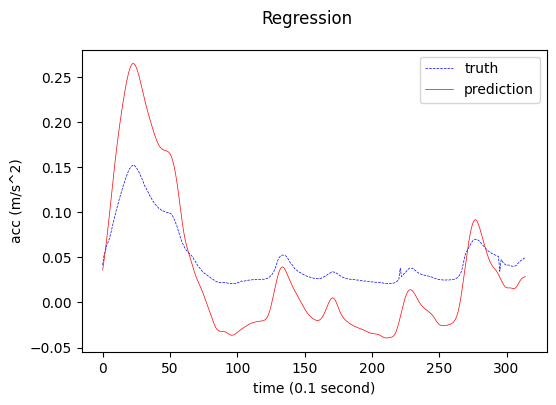

vehicle 72  MSE Loss: 0.00194249


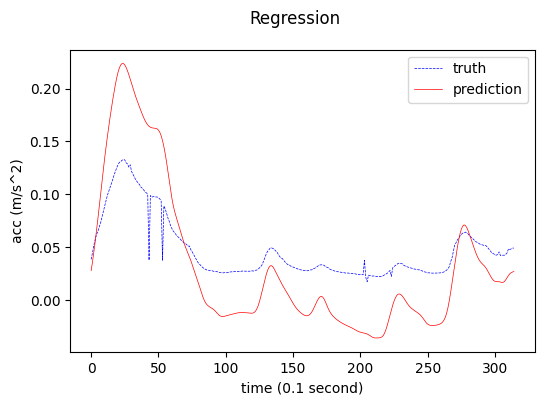

vehicle 73  MSE Loss: 0.00286711


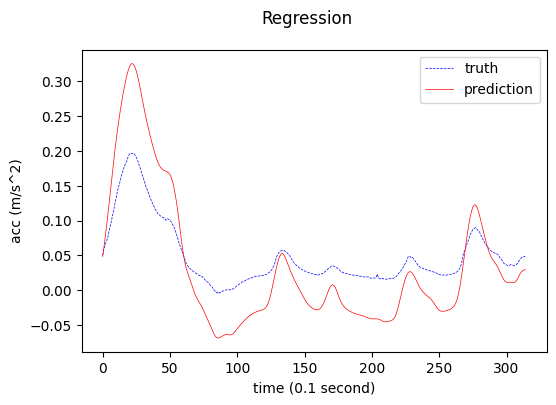

vehicle 74  MSE Loss: 0.00276078


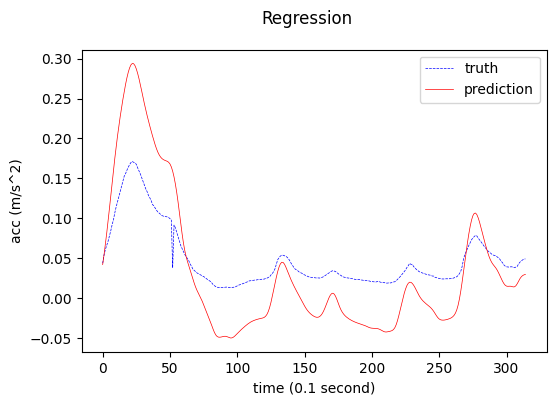

vehicle 75  MSE Loss: 0.00204684


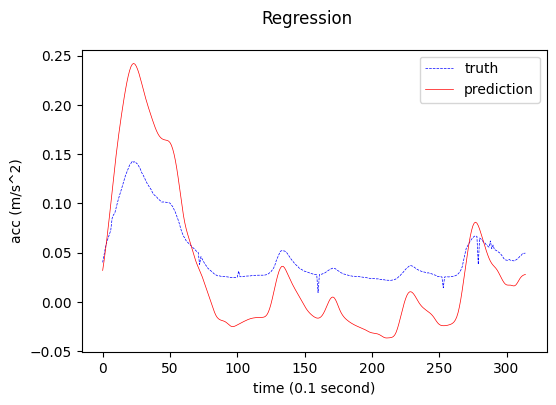

vehicle 76  MSE Loss: 0.00310083


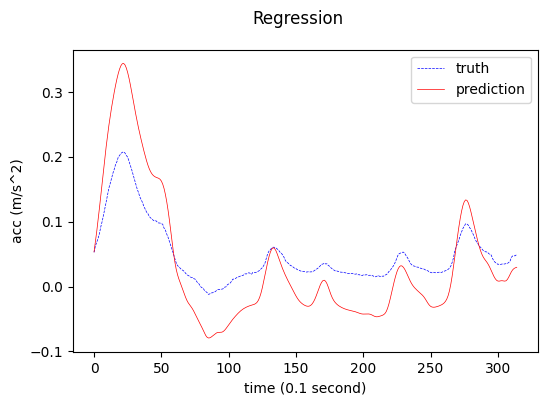

vehicle 77  MSE Loss: 0.00219129


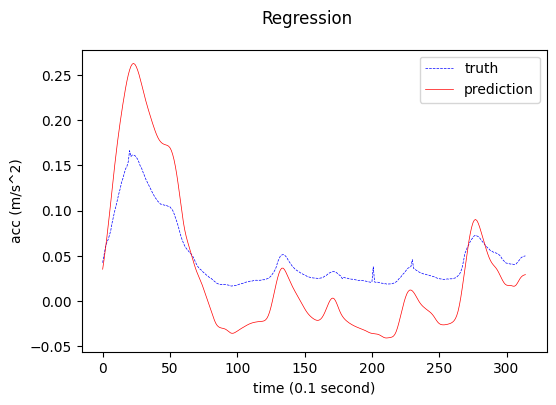

vehicle 78  MSE Loss: 0.00196453


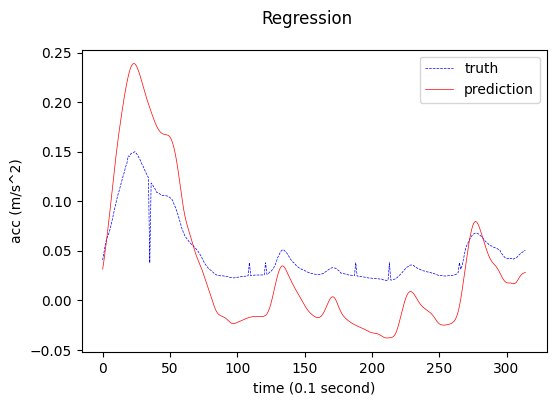

vehicle 79  MSE Loss: 0.00289747


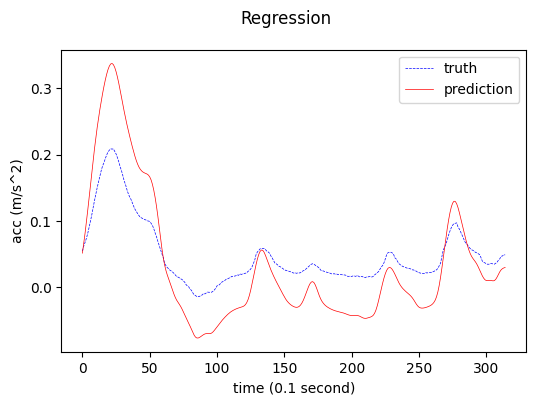

vehicle 80  MSE Loss: 0.00198325


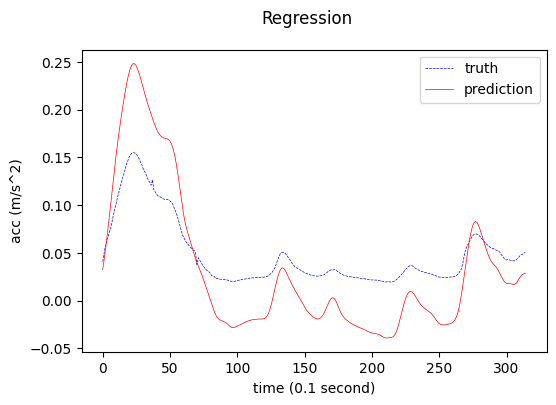

vehicle 81  MSE Loss: 0.00156204


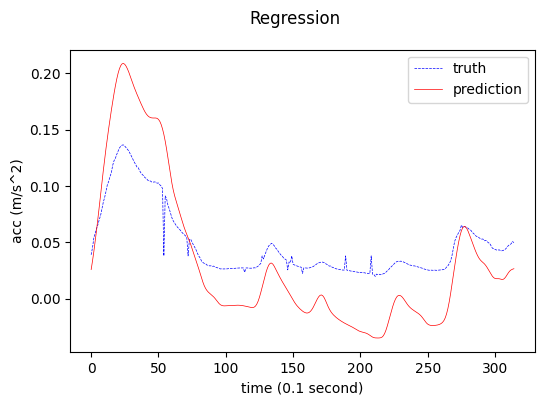

vehicle 82  MSE Loss: 0.00291467


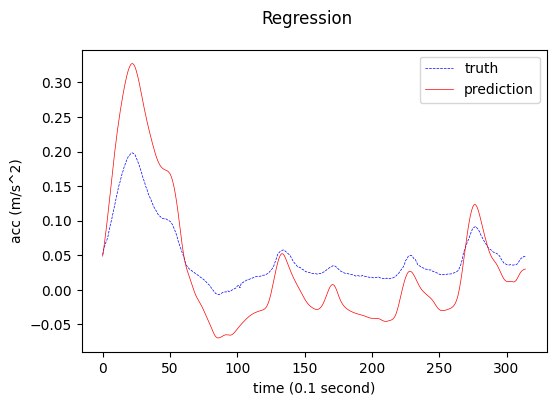

vehicle 83  MSE Loss: 0.00216612


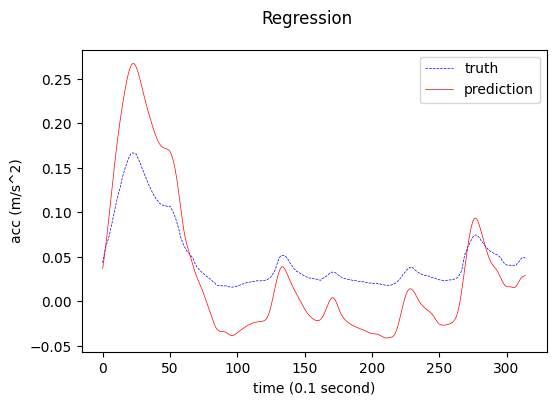

vehicle 84  MSE Loss: 0.00169949


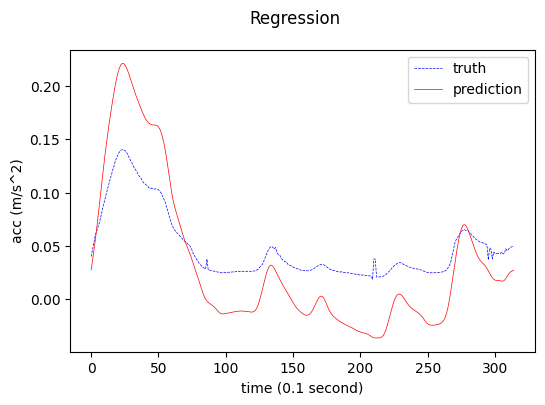

vehicle 85  MSE Loss: 0.00277995


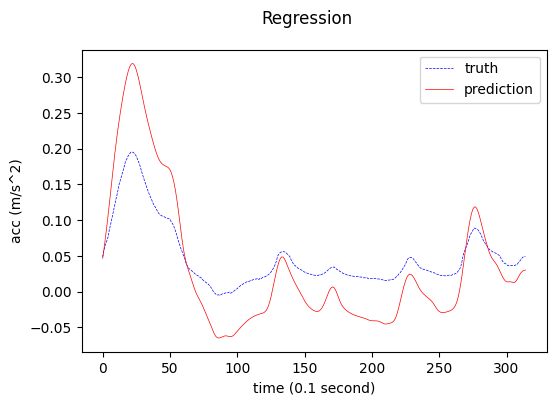

vehicle 86  MSE Loss: 0.00241882


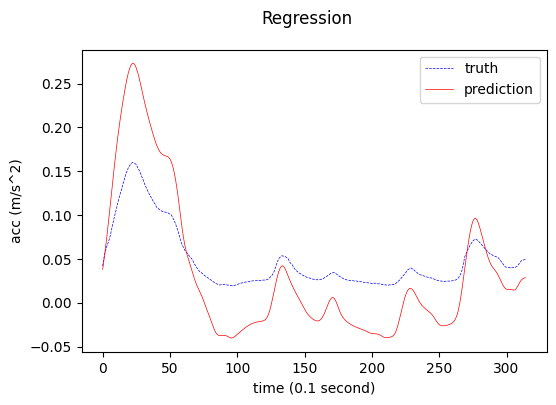

vehicle 87  MSE Loss: 0.00217981


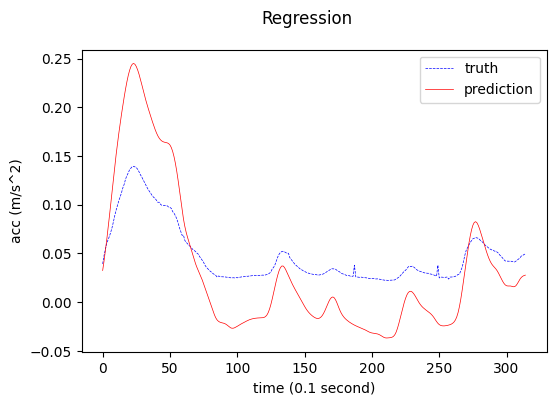

vehicle 88  MSE Loss: 0.00327082


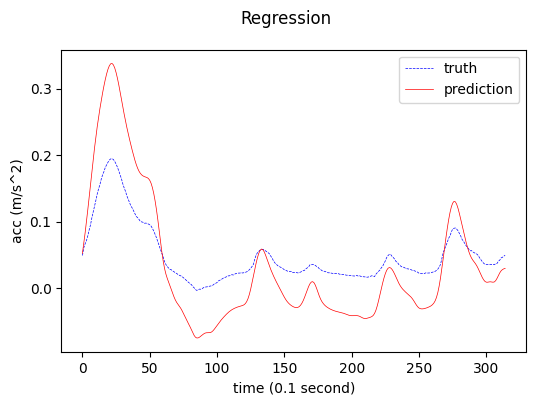

vehicle 89  MSE Loss: 0.00214654


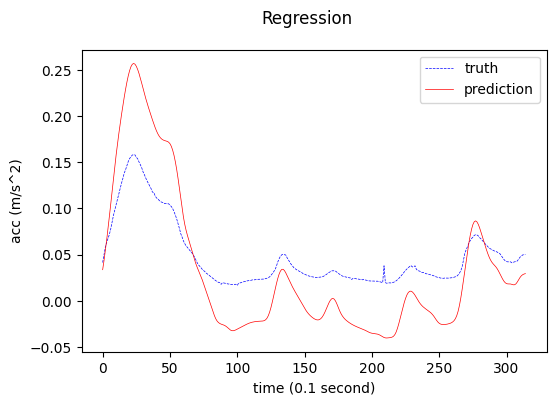

vehicle 90  MSE Loss: 0.00203846


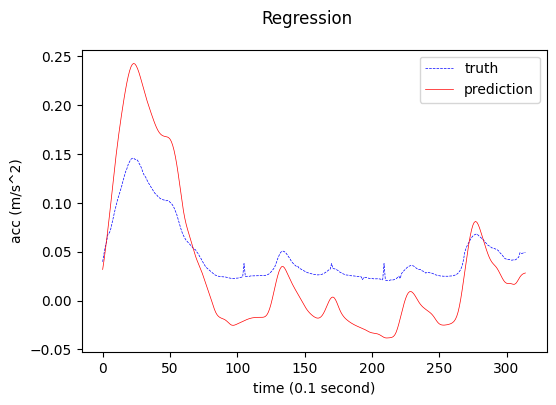

vehicle 91  MSE Loss: 0.00304851


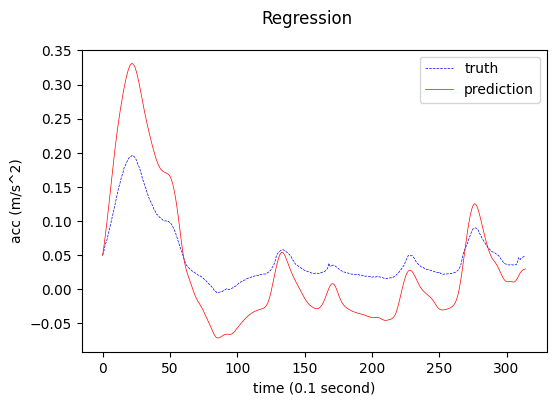

vehicle 92  MSE Loss: 0.00225377


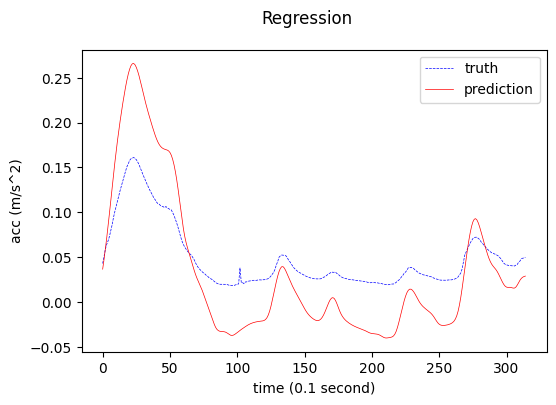

vehicle 93  MSE Loss: 0.00230768


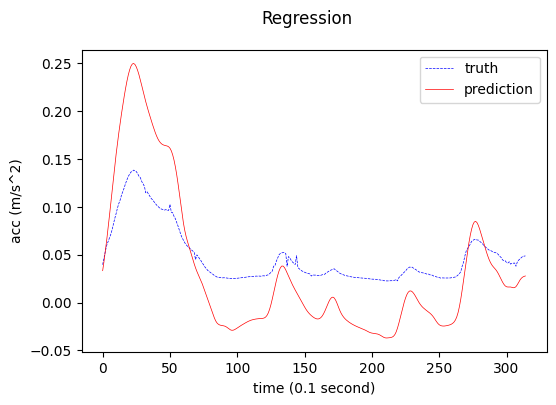

vehicle 94  MSE Loss: 0.00299642


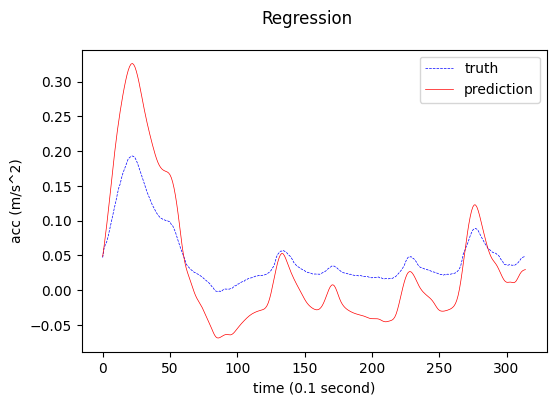

vehicle 95  MSE Loss: 0.00158325


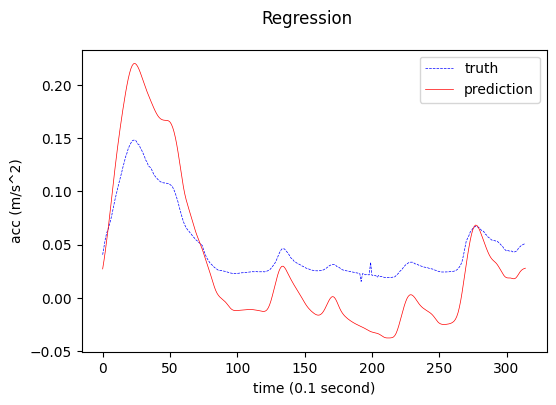

vehicle 96  MSE Loss: 0.00198025


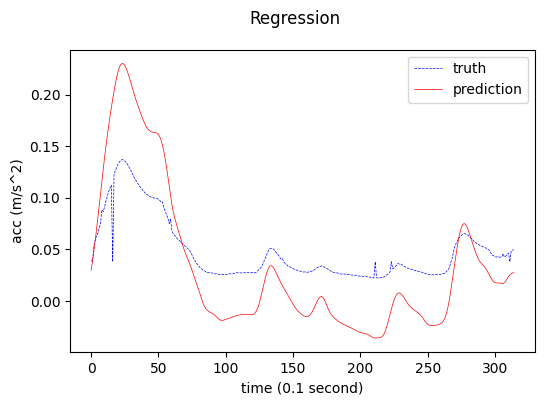

vehicle 97  MSE Loss: 0.00381891


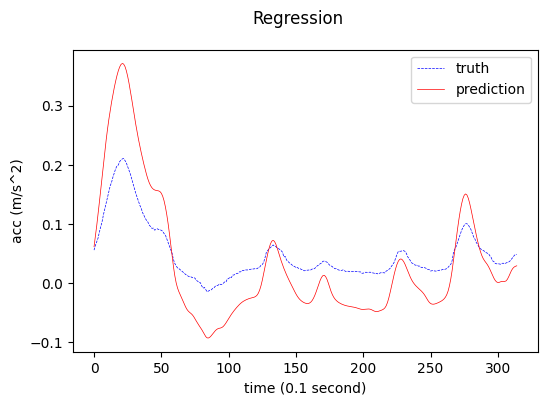

vehicle 98  MSE Loss: 0.00203769


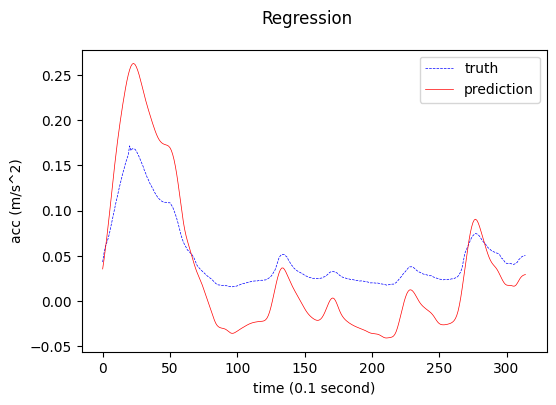

vehicle 99  MSE Loss: 0.00169670


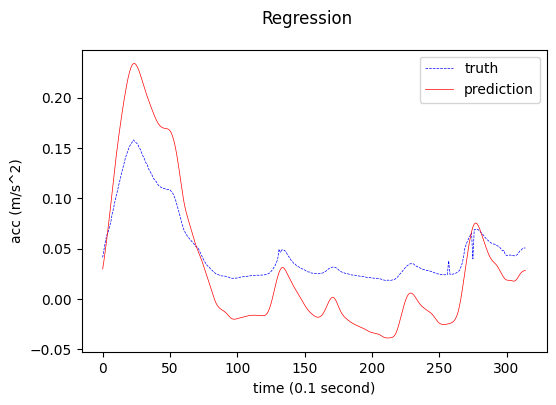

average MSE loss: 0.00230418402235955


In [10]:
MSE = []
num_test = testing_size
test_X = Variable(torch.empty(sample_len, seq_length, 3))
test_Y = Variable(torch.empty(sample_len,1))
    
for k in range(testing_size):
    test_X = testX[k*sample_len:k*sample_len+sample_len] # 0 to test_size
    test_Y = testY[k*sample_len:k*sample_len+sample_len]

    test_X = test_X.to(device)
    test_Y = test_Y.to(device)
    ##########################################
    model.eval()
    predict = model(test_X)
    
    loss = (np.square(predict.cpu().data.numpy() - test_Y.cpu().data.numpy())).mean(axis=None)
    #loss = nn.MSELoss(predict, test_Y)
    MSE.append(loss)
    print("vehicle %d  MSE Loss: %1.8f" % (k, loss.item()))
    plt.figure(dpi=100)
    plt.plot(predict.cpu().data.numpy(),c='b', linewidth=0.5, label = 'truth', linestyle='dashed')
    plt.plot(test_Y.cpu().data.numpy(),c='r', linewidth=0.5, label = 'prediction')
    plt.xlabel('time (0.1 second)')
    plt.ylabel('acc (m/s^2)')
    plt.suptitle('Regression')
    plt.legend()
    plt.show()

print('average MSE loss:', sum(MSE)/num_test)


In [11]:
quit()